# Interpolation and Extrapolation [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ua-2025q3-astr501-513/ua-2025q3-astr501-513.github.io/blob/main/513/04/notes.ipynb)

```{note}
This lecture follows closely
[Numerical Recipes](https://numerical.recipes/) 2nd Edition in C and
3rd Edition in C++, Chapter 3 "Interpolation and Extrapolation".
```

In scientific computing and machine learning, interpolation and
extrapolation are essential methods for estimating unknown values from
known data.

Interpolation deals with predicting values within the range of
available data.
This is the foundation of most supervised learning tasks in machine
learning, where models predict outputs in the same region where they
were trained.
Standard interpolation methods include:
* Polynomial interpolation is flexible but can suffer from
  oscillations at the edges of the interval (Runge's phenomenon).
* Rational interpolation can help stabilize the behavior, especially
  near asymptotes or when functions have strong curvature.
* Spline interpolation, particularly cubic splines, provides smooth
  fits with continuity up to the second derivative.
  This is especially useful when a smooth curve is required, such as
  in modeling or visualization.

Extrapolation extends predictions beyond the available data.
It is inherently unreliable: without additional information, we cannot
know how a function continues beyond the known region.
A promising modern approach is physics-informed machine learning
(PIML), where physical laws such as ODEs are built into the model.
By respecting known constraints, such methods can make extrapolations
that remain consistent with physics.

Interpolation and function approximation are related but slightly
different.
It is useful to distinguish between them:
* Interpolation uses existing data to estimate specific missing
  values.
* Function approximation constructs a simplified function that
  captures the overall behavior of a more complex one.
  It is often for efficiency or analytic convenience.
  (See [Numerical Recipes](https://numerical.recipes/), Chapter 5.)

## Limitations of Interpolation

Even the best interpolation schemes can fail when the function itself
is ill-behaved.
For example:
\begin{align}
  f(x) = 3x^2 + \frac{1}{\pi^4}\ln\left[(\pi - x)^2\right] + 1
\end{align}
This function looks smooth but has a subtle singularity at $x = \pi$.
Interpolating only near the singularity produces misleading results,
as we see in these python plots.

In [1]:
import numpy as np

def f(x):
    return 3 * x**2 + np.log((np.pi - x)**2) / np.pi**4 + 1

x1 = np.linspace(3.13, 3.16, 3+1)     # very sparse
x2 = np.linspace(3.13, 3.16, 30+1)    # coarse
x3 = np.linspace(3.13, 3.16, 300+1)   # medium
x4 = np.linspace(3.13, 3.16, 3000+1)  # dense

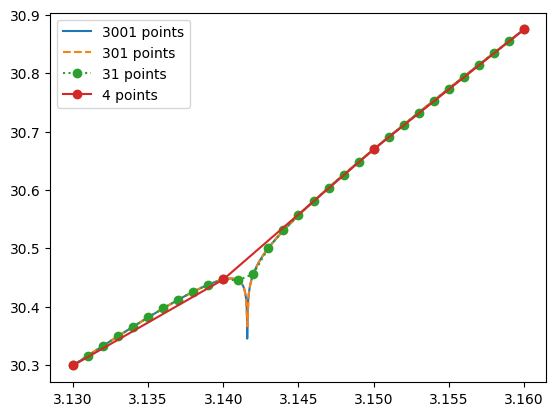

In [2]:
from matplotlib import pyplot as plt

plt.plot(x4, f(x4),       label='3001 points')
plt.plot(x3, f(x3), '--', label='301 points')
plt.plot(x2, f(x2), 'o:', label='31 points')
plt.plot(x1, f(x1), 'o-', label='4 points')
plt.legend()

This example shows why interpolation methods should always be paired
with error estimates and awareness of the underlying physics or
mathematics.

## Preliminaries: Searching an Ordered Table

Before we can interpolate, we need to know where in the dataset our
target value lies.
This step is called searching.
* If data are sampled on a regular grid, finding neighbors is trivial:
  just use the array index.
* If data are irregularly spaced, we must locate the two points that
  bracket the target value.
* This search step can be just as costly as the interpolation itself,
  so efficient methods are critical in practice.
  In fact, in multi-dimension, it may require non-trivial algorithm
  and advanced data structure.

[Numerical Recipes](https://numerical.recipes/) describes two main
approaches: bisection and hunting, each suited to different scenarios.


### Linear Search

As a baseline, let's consider a simple linear search.
It scans through the array until the first value larger than the
target is found.

In [3]:
def linear(X, v):
    for i in range(len(X)):  # use a Python loop for clarity
        if X[i] >= v:
            return i - 1

In [4]:
import numpy as np

for _ in range(5):
    X = np.sort(np.random.uniform(0, 100, 10))
    v = np.random.uniform(min(X), max(X))
    i = linear(X, v)
    assert X[i] <= v and v < X[i+1]
    print(f'{X[i]} <= {v} < {X[i+1]}')

31.176133853427235 <= 32.15907636803446 < 36.27845651009813
51.347171865242224 <= 58.461764879790444 < 72.89972903142794
36.59778144585576 <= 68.63864167332986 < 71.93588435564922
57.377788109475944 <= 70.22483207083624 < 74.01039184817246
67.73069335749739 <= 69.00669442703342 < 89.94180991467681


This works, but it requires $\mathcal{O}(N)$ steps.
For large datasets, this is inefficient.

### Bisection Search

The bisection method is much faster.
It repeatedly halves the search interval until the target is bracketed.
For $N$ data points, it requires only about $\log_2(N)$ steps.

In [5]:
def bisection(X, v):
    l, h = 0, len(X) - 1
    while h - l > 1:
        m = (l + h) // 2
        if v >= X[m]:
            l = m
        else:
            h = m
    return l  # index of the closest value less than the target

In [6]:
for _ in range(5):
    X = np.sort(np.random.uniform(0, 100, 10))
    v = np.random.uniform(min(X), max(X))
    i = bisection(X, v)
    assert X[i] <= v and v < X[i+1]
    print(f'{X[i]} <= {v} < {X[i+1]}')

37.99888228819073 <= 42.499185652948654 < 51.638323796419016
11.82379227474868 <= 17.374282224090496 < 27.174338174003488
11.40445089685429 <= 13.369247320526142 < 13.745558446000594
39.23819803635739 <= 44.556836192533645 < 52.03524182197664
10.471188447832414 <= 12.855689085880513 < 16.369666611374278


This method is robust and efficient for uncorrelated queries, where
each target value is unrelated to the previous one.

### Hunting Method

If target values are requested in sequence and tend to be close to one
another, we can do even better.
The hunting method exploits this correlation:
1. Start near the last found index.
2. Step outward (doubling the step size each time) until the target is
   bracketed.
3. Refine the result using bisection in the narrowed interval.
This approach is often faster than starting from scratch with
bisection every time.

In [7]:
def hunt(X, v, i_last):
    n = len(X)
    assert 0 <= i_last < n - 1

    if v >= X[i_last]:
        l, h, step = i_last, min(n-1, i_last+1), 1
        while h < n - 1 and v > X[h]:
            l, h = h, min(n-1, h + step)
            step *= 2
    else:
        l, h, step = max(0, i_last-1), i_last, 1
        while l > 0 and v < X[l]:
            l, h = max(0, l - step), l
            step *= 2

    return bisection(X[l:h+1], v) + l

In [8]:
for _ in range(5):
    X = np.sort(np.random.uniform(0, 100, 10))
    v = np.random.uniform(min(X), max(X))
    i = bisection(X, v)
    assert X[i] <= v and v < X[i+1]
    print(f'{X[i]} <= {v} < {X[i+1]}')

67.81439792226539 <= 78.86293657654261 < 92.55144568182011
26.876524441692307 <= 37.5502953237929 < 38.54773220555812
52.69595734468182 <= 79.1278418612532 < 90.1322012882293
28.806570771514327 <= 36.80827889978012 < 42.07916185528746
41.389681727978775 <= 44.943774525675664 < 48.27748179305923


## Linear Interpolation with Searching

With a search routine in place, interpolation becomes straightforward.
Below is a simple interpolator that supports hunt, bisection, or
linear searching.

In [9]:
class Interpolator:
    
    def __init__(self, X, Y):
        assert len(X) == len(Y)
        self.X, self.Y = X, Y
        self.i_last = len(X) // 2

    def __call__(self, v, method='hunt'):
        if method == 'hunt':
            i = hunt(self.X, v, self.i_last)
        elif method == 'bisection':
            i = bisection(self.X, v)
        else:
            i = linear(self.X, v)

        self.i_last = i  # store last index for hunting

        x0, x1 = self.X[i], self.X[i+1]
        y0, y1 = self.Y[i], self.Y[i+1]
        m      = (y1 - y0) / (x1 - x0)
        return y0 + m * (v - x0)

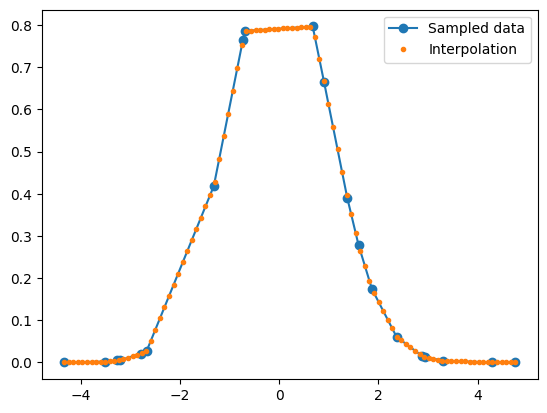

In [10]:
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-0.5 * x**2)

Xs = np.sort(np.random.uniform(-5, 5, 20))
Ys = f(Xs)

fi = Interpolator(Xs, Ys)

Xi = np.linspace(min(Xs), max(Xs), 100)
Yi = np.array([fi(x) for x in Xi])

plt.plot(Xs, Ys, 'o-', label='Sampled data')
plt.plot(Xi, Yi, '.',  label='Interpolation')
plt.legend()
plt.show()

Finally, let's test our claim: hunting should be faster than bisection
when queries are sequential and correlated.

In [11]:
from timeit import timeit

Xs = np.sort(np.random.uniform(-5, 5, 1000))
Ys = f(Xs)
fi = Interpolator(Xs, Ys)
Xi = np.linspace(min(Xs), max(Xs), 10_000)

def job(method):
    Yi = [fi(x, method) for x in Xi]

dt_linear    = timeit("job('linear')",    globals=globals(), number=1)
dt_bisection = timeit("job('bisection')", globals=globals(), number=1)
dt_hunt      = timeit("job('hunt')",      globals=globals(), number=1)

In [12]:
print('Linear   :', dt_linear)
print('Bisection:', dt_bisection)
print('Hunt     :', dt_hunt)

Linear   : 0.6211810980021255
Bisection: 0.03016846200625878
Hunt     : 0.01707720999547746


In [ ]:
# HANDSON: change the number of sampled points and interpolation
#          points and measure the performance of all three methods.
#          What are the performance characteristics when
#          N_sample >> N_interpolation and
#          N_sample << N_interpolation?


```{note} Main Take Away

It may seem surprising that interpolation, which sounds like purely
numerical, actually spends much of its effort on searching.
The interpolation formula itself is simple, but locating the right
interval in the data dominates the work.

This may be less surprising if we start asking ourselves what are
computers good at?
Certainly at arithmetic, but equally at bookkeeping (and communication
now when we have internet).
In fact, much of computer science is devoted to studying how to
organize and retrieve data efficiently.
This is what "data structures and algorithms" are about.
Searching in interpolation is a great example of this.
Efficient bookkeeping can matter as much as the numerical formula.

Our codes here were one-dimensional and simple.
But in practice, many scientific applications require multidimensional
interpolation.
In higher dimensions, the search problem quickly becomes far more
complicated.
Efficient methods often rely on tree structures (e.g., kd-trees or
octrees) to organize points and make search practical.
This is the same kind of complexity that appears in $n$-body
simulations and particle-mesh algorithms, where bookkeeping and
efficient search dominate performance.

Thus, linear interpolation serves as a small but important lesson:
computational science (i.e., numerical analysis) and computer science
are deeply connected.
To do science at scale, one must care not only about the equations,
but also about how data are organized and searched.
```

## Polynomial Interpolation and Extrapolation

Given $M$ data points $(x_0, y_0), (x_1, y_1), \dots, (x_{M-1},
y_{M_1})$, there exists a unique polynomial of degree $M-1$ that
passes through all of them exactly.

### Lagrange's Formula

The classical formula due to Lagrange writes this polynomial as
\begin{align}
  P_{M-1}(x)
  &= \frac{(x-x_1)(x-x_2)\dots(x-x_{M-1})}{(x_0-x_1)(x_0-x_2)\dots(x_0-x_{M-1})} y_0 \\
  &+ \frac{(x-x_0)(x-x_2)\dots(x-x_{M-1})}{(x_1-x_0)(x_1-x_2)\dots(x_1-x_{M-1})} y_1 + \dots \\
  &+ \frac{(x-x_0)(x-x_2)\dots(x-x_{M-2})}{(x_{M-1}-x_0)(x_{M-1}-x_1)\dots(x_{M-1}-x_{M-2})} y_{M-1}.
\end{align}

Using summation and product notation, we can write this more compactly as
\begin{align}
  P_{M-1}(x)
  = \sum_{m=0}^{M-1} \frac{\prod_{n=0,n\ne m}^{M-1}(x-x_n)}{\prod_{n=0,n\ne m}^{M-1}(x_m-x_n)} y_m.
\end{align}

It is straightforward to check that substituting $x = x_{m'}$ gives
\begin{align}
  P_{M-1}(x_{m'})
  = \sum_{m=0}^{M-1} \delta_{mm'} y_m
\end{align}
so the polynomial indeed passes through all the data points.

### Neville's Algorithm

While Lagrange's formula is mathematically elegant, it is not the most
practical for computation:
* It does not directly provide an error estimate.
* It requires recomputation for each new interpolation point.
A better approach is Neville's Algorithm, which recursively builds the
interpolating polynomial and naturally provides error estimates.
This makes it especially useful for small to moderate datasets.

### Step 1: Zero-Degree Polynomials

A polynomial of degree 0 is just a constant.
For each data point $(x_m, y_m)$, define
\begin{align}
  P_m(x) = y_m
\end{align}
These form the base case for the recursion.

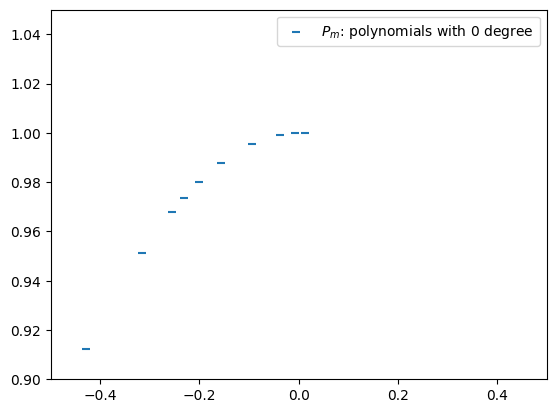

In [13]:
Xs = np.sort(np.random.uniform(-5, 5, 100))
Ys = f(Xs)

plt.scatter(Xs, Ys, marker='_', color='C0', label=r'$P_m$: polynomials with 0 degree')
plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

#### Step 2: First-Degree Polynomials

We now interpolate between two neighboring points $(x_{m'}, y_{m'})$
and $(x_{m'+1}, y_{m'+1})$.
This gives a linear polynomial, denoted $P_{m',m'+1}(x)$:
\begin{align}
  \frac{P_{m',m'+1} - P_{m'}}{x - x_{m'}} &= \frac{P_{m'+1} - P_{m'}}{x_{m'+1} - x_{m'}} \\
  P_{m',m'+1} - P_{m'} &= \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
  P_{m',m'+1} &= P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
  P_{m',m'+1} &= \frac{x_{m'+1} - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
  P_{m',m'+1} &= \left(\frac{x_{m'+1} - x_{m'}}{x_{m'+1} - x_{m'}} - \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}\right)P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'+1} \\
  P_{m',m'+1} &= \frac{x_{m'+1} - x}{x_{m'+1} - x_{m'}}P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'+1} \\
  P_{m',m'+1} &= \frac{(x - x_{m'+1})P_{m'} + (x_{m'} - x)P_{m'+1} }{x_{m'} - x_{m'+1}}
\end{align}
This is simply the two-point form of a line.

In [14]:
Pmm1s = []
for m in range(len(Xs)-1):
    Pmm1s.append(lambda x: ((x - Xs[m+1]) * Ys[m] + (Xs[m] - x) * Ys[m+1]) / (Xs[m] - Xs[m+1]))

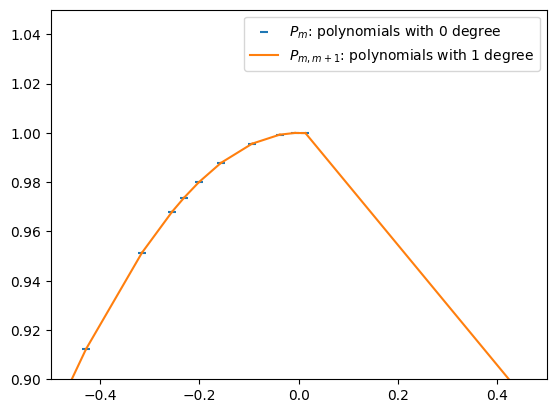

In [15]:
plt.scatter(Xs, Ys, marker='_', color='C0', label=r'$P_m$: polynomials with 0 degree')

label = r'$P_{m,m+1}$: polynomials with 1 degree'
for m, Pmm1 in enumerate(Pmm1s):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1(xs)
    plt.plot(xs, ys, color='C1', label=label)
    label = None

plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

#### Step 3: Second-Degree Polynomials

By interpolating two neighboring first-degree polynomials, we obtain a
second-degree polynomial:
\begin{align}
  P_{m'',m''+1,m''+2}
  &= \frac{(x - x_{m''+2})P_{m'',m''+1} + (x_{m''} - x)P_{m''+1,m''+2} }{x_{m'} - x_{m'+2}}.
\end{align}

In [16]:
Pmm1m2s = []
for m in range(len(Xs)-2):
    Pmm1  = lambda x: ((x - Xs[m+1]) * Ys[m  ] + (Xs[m  ] - x) * Ys[m+1]) / (Xs[m  ] - Xs[m+1])
    Pm1m2 = lambda x: ((x - Xs[m+2]) * Ys[m+1] + (Xs[m+1] - x) * Ys[m+2]) / (Xs[m+1] - Xs[m+2])
    Pmm1m2s.append(
        lambda x: ((x - Xs[m+2]) * Pmm1(x) + (Xs[m] - x) * Pm1m2(x)) / (Xs[m] - Xs[m+2])
    )

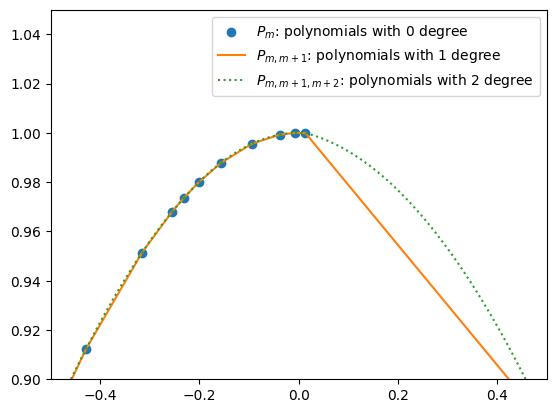

In [17]:
plt.scatter(Xs, Ys, marker='o', color='C0', label=r'$P_m$: polynomials with 0 degree')

label = r'$P_{m,m+1}$: polynomials with 1 degree'
for m, Pmm1 in enumerate(Pmm1s[:-1]):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1(xs)
    plt.plot(xs, ys, color='C1', label=label)
    label = None

label = r'$P_{m,m+1,m+2}$: polynomials with 2 degree'
for m, Pmm1m2 in enumerate(Pmm1m2s):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1m2(xs)
    plt.plot(xs, ys, ':', color='C2', label=label)
    label = None

plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

#### Step 4: Recursive Formula

By continuing this process, we arrive at the general recursive formula
for Neville's algorithm (Numerical Recipes Eq. 3.2.3):
\begin{align}
   P_{m,m+1,\dots,m+n}
   &= \frac{(x - x_{m+n})P_{m,m+1,\dots,m+n-1} + (x_{m} - x)P_{m+1,m+2,\dots,m+n} }{x_{m} - x_{m+n}}.
\end{align}
This provides a systematic way to build higher-order interpolating polynomials.

#### Step 5: Avoiding Catastrophic Cancellation

Direct implementation of the above formulations may suffer from
catastrophic cancellation, especially when points are close together.
Numerical Recipes reformulates the recursion in terms of small
corrections $C_{n,m}$ and $D_{n,m}$:
\begin{align}
  C_{n,m} &\equiv P_{m,m+1,\dots,m+n} - P_{m,m+1,\dots,m+n-1} \\
  D_{n,m} &\equiv P_{m,m+1,\dots,m+n} - P_{m+1,m+2,\dots,m+n}
\end{align}
These track the incremental updates that improve accuracy.

Neville's algorithm can now be rewritten as
\begin{align}
  D_{n+1,m} &= \frac{x_{m+n+1}-x}{x_m - x_{m+n+1}}(C_{n,m+1} - D_{n,m}) \\
  C_{n+1,m} &= \frac{x_{n}-x}{x_m - x_{m+n+1}}(C_{n,m+1} - D_{n,m})
\end{align}
From this expression, it is now clear that the $C$'s and $D$'s are the
corrections that make the interpolation one order higher.

#### Step 6. Implementation

The final polynomial $P_{0,1,\dots,M-1}$ is equal to the sum of any
$y_i$ plus a set of $C$'s and/or $D$'s that form a path through the
family tree of $P_{m,m+1,\dots,m+n}$.

In [18]:
class PolynomialInterpolator:
    
    def __init__(self, Xs, Ys, n=None):
        if n is None:
            n = len(Xs)

        assert len(Xs) == len(Ys)
        assert len(Xs) >= n

        self.Xs, self.Ys, self.n = Xs, Ys, n

    def __call__(self, target, search_method='hunt'):

        C = np.copy(self.Ys)
        D = np.copy(self.Ys)

        i = np.argmin(abs(self.Xs - target))
        y = self.Ys[i]
        i-= 1

        for n in range(1,self.n):
            ho  = self.Xs[:-n] - target
            hp  = self.Xs[+n:] - target
            w   = C[1:self.n-n+1] - D[:-n]
            den = ho - hp
            if any(den == 0):
                raise Exception("two input Xs are (to within roundoﬀ) identical.")
            else:
                f = w / den
            D[:-n] = hp * f
            C[:-n] = ho * f

            if 2*(i+1) < (self.n-n):
                self.dy = C[i+1]
            else:
                self.dy = D[i]
                i -= 1

            y += self.dy

        return y

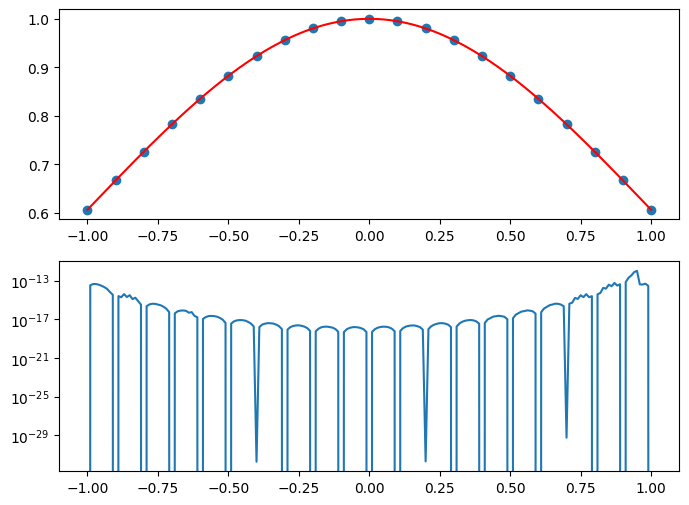

In [19]:
Xs = np.linspace(-1,1,21)
Ys = f(Xs)

P  = PolynomialInterpolator(Xs, Ys)

Xi = np.linspace(min(Xs),max(Xs),201)
Yi = []
Ei = []
for x in Xi:
    Yi.append(P(x))
    Ei.append(P.dy)
Yi = np.array(Yi)
Ei = np.array(Ei)

fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].scatter(Xs, Ys)
axes[0].plot(Xi, Yi, '-', color='r')
axes[1].semilogy(Xi, abs(Ei))

In [ ]:
# HANDSON: Change the sampling points to, e.g.,
#
#              Xs = np.linspace(-5,5,21)
#              Xs = -5 * np.cos(np.linspace(0, np.pi, 21))
#
#          How does the error converge if we increase (or decrease)
#          the number of sampling points?
#          What will happen if we increase the size of the domain?
#          (This is called Runge phenomenon.)
#          What will happen if we try to extrapolate?


In [ ]:
# HANDSON: Our interpolator can take different order of
#          approximations.
#          Create convergence plots and study the error as function of
#          the order.
#          What happen when we have different domain size?
#          What happen when we have different sampling points?


## More Interpolation Algorithms

For further study, here are several powerful alternatives and
extensions to polynomial interpolation:
* Cubic Splines:
  Ensure smoothness across intervals by matching derivatives at knots,
  avoiding the oscillations of high-degree polynomials.
* Rational Function Interpolation:
  Use ratios of polynomials to capture asymptotic behavior and improve
  stability.
* Direct Polynomial Coefficients:
  Compute coefficients efficiently (e.g., via Newton's form) when
  polynomials are truly required.
* Multidimensional Interpolation:
  Extend interpolation to higher dimensions, important for
  applications such as spatial data analysis and numerical
  simulations.
* Laplace Interpolation:
  A specialized technique for harmonic functions, using properties of
  Laplace's equation.

Interpolation is not one-size-fits-all.
Polynomial methods are elegant and instructive, but understanding
their strengths and weaknesses is important.
By combining them with more advanced techniques, we can handle a much
wider range of problems in scientific computing.

Instead of re-deriving or implementing all of these algorithms from
scratch, we will try out a few of them using built-in functions from
`numpy` and `scipy`.
This will give us hands-on experience with practical tools while
reinforcing the ideas we have discussed.

### Cubic Splines

The classical choice for smooth interpolation is the cubic spline.
It guarantees continuity of the function, its first derivative, and
its second derivative across intervals.

(0.9, 1.05)

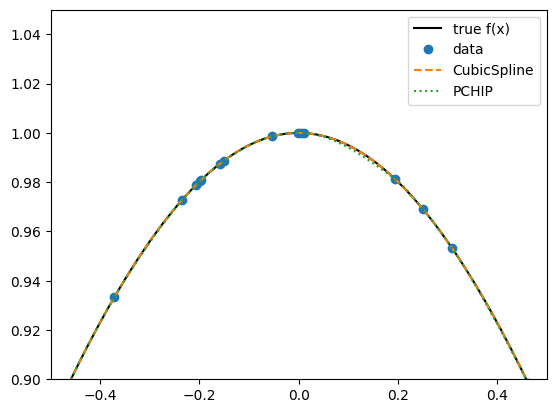

In [20]:
from scipy.interpolate import CubicSpline, PchipInterpolator

Xs = np.sort(np.random.uniform(-3, 3, 100))
Ys = f(Xs)

CS    = CubicSpline(Xs, Ys)        # classical cubic spline
Pchip = PchipInterpolator(Xs, Ys)  # monotone, shape-preserving

Xi = np.linspace(-3, 3, 1000)

plt.plot(Xi, f(Xi),     'k',  label='true f(x)')
plt.plot(Xs, Ys,        'o',  label='data')
plt.plot(Xi, CS(Xi),    '--', label='CubicSpline')
plt.plot(Xi, Pchip(Xi), ':',  label='PCHIP')
plt.legend()

plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)

In [ ]:
# HANDSON: add some noise to the data and compare `CubicSpline`
#          vs. `PchipInterpolator`.
#          Which one is more robust against oscillations?


### Multidimensional Interpolation

Interpolation often appears in 2D or 3D. SciPy provides two useful
tools:
* `griddata`: works with scattered data.
* `RegularGridInterpolator`: efficient for regular grids.

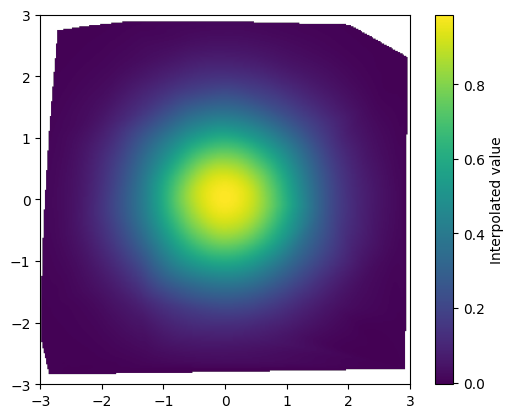

In [21]:
from scipy.interpolate import griddata

Xs = np.random.uniform(-3, 3, 100)
Ys = np.random.uniform(-3, 3, 100)
Zs = f(np.sqrt(Xs * Xs + Ys * Ys))

# Interpolate on a grid
Xg, Yg = np.meshgrid(
    np.linspace(-3, 3, 301),
    np.linspace(-3, 3, 301),
    indexing='xy')
Zg = griddata((Xs, Ys), Zs, (Xg, Yg), method='cubic')

plt.imshow(Zg, extent=[-3,3,-3,3], origin='lower')
plt.colorbar(label='Interpolated value')

In [ ]:
# HANDSON: 
#
# 1. Why is the outer shape of the plot irregular?
#
# 2. Adjust the number of sampling points and interpolation points.
#    How does the resulting plots look like?
#
# 3. Try methods 'linear', 'nearest', and 'cubic'.
#    Compare smoothness vs. accuracy.


In [ ]:
# HANDSON: try to use `RegularGridInterpolator` to interpolate on a
#          regular grid.
